# Import packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# Grid

In [2]:
iB = 6
tsnap = 2

path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
# hFacCpartial = mygrid['hFacC']
# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
print(hf1.shape)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)


In [4]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

10650


In [5]:
# 2d
inf = h5py.File(dirgridw + 'Index_wet_hfacC_2D.mat')
arr = inf['ind'][:]
iwetC2d = arr[5,:]
iwetC2d = iwetC2d.astype("int32")
iwetC2d -= 1
LwetC2d = iwetC2d.shape[0]
print("LwetC2d",LwetC2d)

# 3d
inf = h5py.File(dirgridw + "Index_wet_hfacC.mat")
arr = inf['ind'][:]
iwetC = arr[5,:]
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]
print("LwetC",LwetC)

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

# load the gateways
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    #mskBasin = (inf["mskBasin"])
    ggate  = inf['ggate']
    ggate2  = inf['ggate2']
    
num = 1
for i in ggate[0]:
    label = i[0][0][0]
    # print(num,label)
    num += 1
print()

num = 1
for i in ggate2[0]:
    label = (i[0][0][-2])
    # print(num,label)
    num += 1

# we have to first make a dictionary
gg = {}
ggate1 = ggate[0]
for mygate in ggate1:
    name = mygate[0][0][0][0]
    gg[name] = {}
    gg[name]['ix'] = mygate[0][0][1][0]
    gg[name]['jy'] = mygate[0][0][2][0]
    gg[name]['signu'] = mygate[0][0][3][0]
    gg[name]['signv'] = mygate[0][0][4][0]
    gg[name]['descr'] = mygate[0][0][5][0]

gg2 = {}
ggate2a = ggate2[0]
for mygate in ggate2a:
    name = mygate[0][0][4][0]
    gg2[name] = {}
    gg2[name]['ix'] = mygate[0][0][0][0]
    gg2[name]['jy'] = mygate[0][0][1][0]
    gg2[name]['signu'] = mygate[0][0][2][0]
    gg2[name]['signv'] = mygate[0][0][3][0]
    gg2[name]['descr'] = mygate[0][0][5][0]

# check with An to see if these are the same values
for igate in gg.keys():
    L = len(gg[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg[igate]['jy'][i] - 1) * nx + gg[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg[igate]['indwet'] = indwet
    gg[igate]['ivalid'] = ivalid

# check with An to see if these are the same values
for igate in gg2.keys():
    L = len(gg2[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg2[igate]['jy'][i] - 1) * nx + gg2[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg2[igate]['indwet'] = indwet
    gg2[igate]['ivalid'] = ivalid

LwetC2d 146614
LwetC 4833023



# Read in the transport files

In [6]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [7]:
# we want temperature and salt
THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)

for i in range(len(tsstr)):

    # read the fldList
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["THETADR","SALTDR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
    read = [int(tsstr[i])]
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m

    THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
    SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [8]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.full((len(tsstr),nz, ny, nx),np.nan)
ETANS = np.full((len(tsstr),ny,nx),np.nan)
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx)) #* wetmask[0,:,:]

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol

print(vol.shape)

volume allocation shape (13, 50, 1350, 270)
(13, 50, 1350, 270)


In [11]:
# get velocity fields
# read timesteps at index 1 and 3
UVELMASS = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
VVELMASS = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
ADVx_TH = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
ADVy_TH = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
DFxE_TH = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
DFyE_TH = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
ADVx_SLT = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
ADVy_SLT = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
DFxE_SLT = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
DFyE_SLT = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

# read the averages from tsstr[1] and tsstr[3] - averages from March and September
# start from 1 because these are averages
for i in range(0,len(tsstr)-1):

    meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[i+1] + '.meta')
    fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
    varnames = np.array(['UVELMASS','VVELMASS','ADVx_TH','ADVy_TH','DFxE_TH','DFyE_TH','ADVx_SLT','ADVy_SLT','DFxE_SLT','DFyE_SLT'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    UVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i+1]),returnmeta=True,rec = recs[0])     # m/s
    VVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i+1]),returnmeta=True,rec = recs[1])     # m/s
    ADVx_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[2])        # degC.m^3/s
    ADVy_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[3])        # degC.m^3/s
    DFxE_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[4])        # degC.m^3/s
    DFyE_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[5])        # degC.m^3/s
    ADVx_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[6])       # psu.m^3/s
    ADVy_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[7])       # psu.m^3/s
    DFxE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[8])       # psu.m^3/s
    DFyE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[9])       # psu.m^3/s
    
    # reshaping and fixing up
    UVELMASS[i,:,:,:] = UVELMASSi.reshape(nz,ny,nx)
    VVELMASS[i,:,:,:] = VVELMASSi.reshape(nz,ny,nx)
    ADVx_TH[i,:,:,:] = ADVx_THi.reshape(nz,ny,nx)
    ADVy_TH[i,:,:,:] = ADVy_THi.reshape(nz,ny,nx)
    DFxE_TH[i,:,:,:] = DFxE_THi.reshape(nz,ny,nx)
    DFyE_TH[i,:,:,:] = DFyE_THi.reshape(nz,ny,nx)
    ADVx_SLT[i,:,:,:] = ADVx_SLTi.reshape(nz,ny,nx)
    ADVy_SLT[i,:,:,:] = ADVy_SLTi.reshape(nz,ny,nx)
    DFxE_SLT[i,:,:,:] = DFxE_SLTi.reshape(nz,ny,nx)
    DFyE_SLT[i,:,:,:] = DFyE_SLTi.reshape(nz,ny,nx)

In [10]:
# read from budg3d_zflux_set2
# 'WVELMASS' 'ADVr_TH ' 'DFrE_TH ' 'DFrI_TH ' 'ADVr_SLT' 'DFrE_SLT' 'DFrI_SLT'
# get velocity fields
# read timesteps at index 1 and 3
WVELMASS = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
ADVr_TH = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
DFrE_TH = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
DFrI_TH = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
ADVr_SLT = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
DFrE_SLT = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
DFrI_SLT = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

meta_budg3d_zflux_set2= parsemeta(dirIn + "budg3d_zflux_set2" + '.' + tsstr[i+1] + '.meta')
fldlist = np.array(meta_budg3d_zflux_set2['fldList'])
varnames = np.array(['WVELMASS','ADVr_TH','DFrE_TH','DFrI_TH','ADVr_SLT','DFrE_SLT','DFrI_SLT'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# read the averages from tsstr[1] and tsstr[3] - averages from March and September
# start from 1 because these are averages
for i in range(0,len(tsstr)-1):
    WVELMASSi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i+1]),returnmeta=True,rec = recs[0])     # m/s
    ADVr_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i+1]),returnmeta=True,rec = recs[1])     # degC/m/s
    DFrE_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[2])        # degC.m^3/s
    DFrI_THi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[3])        # degC.m^3/s
    ADVr_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[4])        # psu.m^3/s
    DFrE_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[5])        # psu.m^3/s
    DFrI_SLTi,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[i]),returnmeta=True,rec = recs[6])       # psu.m^3/s
    
    # reshaping and fixing up
    WVELMASS[i,:,:,:] = WVELMASSi.reshape(nz,ny,nx)
    ADVr_TH[i,:,:,:] = ADVr_THi.reshape(nz,ny,nx)
    DFrE_TH[i,:,:,:] = DFrE_THi.reshape(nz,ny,nx)
    DFrI_TH[i,:,:,:] = DFrI_THi.reshape(nz,ny,nx)
    ADVr_SLT[i,:,:,:] = ADVr_SLTi.reshape(nz,ny,nx)
    DFrE_SLT[i,:,:,:] = DFrE_SLTi.reshape(nz,ny,nx)
    DFrI_SLT[i,:,:,:] = DFrI_SLTi.reshape(nz,ny,nx)

In [12]:
# take means of these for memory storage, can change later
UVELMASS = np.nanmean(UVELMASS,axis=0)
VVELMASS = np.nanmean(VVELMASS,axis=0)
ADVx_TH = np.nanmean(ADVx_TH,axis=0)
ADVy_TH = np.nanmean(ADVy_TH,axis=0)
DFxE_TH = np.nanmean(DFxE_TH,axis=0)
DFyE_TH = np.nanmean(DFyE_TH,axis=0)
ADVx_SLT = np.nanmean(ADVx_SLT,axis=0)
ADVy_SLT = np.nanmean(ADVy_SLT,axis=0)
DFxE_SLT = np.nanmean(DFxE_SLT,axis=0)
DFyE_SLT = np.nanmean(DFyE_SLT,axis=0)

In [13]:
# take means of these for memory storage, can change later
WVELMASS = np.nanmean(WVELMASS,axis=0)
ADVr_TH = np.nanmean(ADVr_TH,axis=0)
DFrE_TH = np.nanmean(DFrE_TH,axis=0)
DFrI_TH = np.nanmean(DFrI_TH,axis=0)
ADVr_SLT = np.nanmean(ADVr_SLT,axis=0)
DFrE_SLT = np.nanmean(DFrE_SLT,axis=0)
DFrI_SLT = np.nanmean(DFrI_SLT,axis=0)

In [16]:
# get the vectors of u and v without mass weighting
Uo = np.full((nz,ny-nfy[0]+1,nfx[0]*2+1),np.nan)
Vo = np.full((nz,ny-nfy[0]+1,nfx[0]*2+1),np.nan)
ADVx_THo = np.full((nz,ny-nfy[0]+1,nfx[0]*2+1),np.nan)
ADVy_THo = np.full((nz,ny-nfy[0]+1,nfx[0]*2+1),np.nan)
DFxE_THo = np.full((nz,ny-nfy[0]+1,nfx[0]*2+1),np.nan)
DFyE_THo = np.full((nz,ny-nfy[0]+1,nfx[0]*2+1),np.nan)

# for i in range((int(len(tsstr)-1))):
for i in range((int(len(tsstr)-1))):
    # get values from reading before
    tmpU = UVELMASS[i]
    tmpV = VVELMASS[i]
    tmpUadvth = ADVx_TH[i]
    tmpVadvth = ADVy_TH[i]
    tmpUdfth = DFxE_TH[i]
    tmpVdfth = DFyE_TH[i]

    # get the vectors defined above
    tmpUo,tmpVo = get_aste_vector_face1_3(tmpU,tmpV,nfx,nfy,False)
    tmpUadvth,tmpVadvth = get_aste_vector_face1_3(tmpUadvth,tmpVadvth,nfx,nfy,False)
    tmpUdfth,tmpVdfth = get_aste_vector_face1_3(tmpUdfth,tmpVdfth,nfx,nfy,False)

    # add to larger arrays
    Uo[i] = tmpUo
    Vo[i] = tmpVo
    ADVx_THo[i] = tmpUadvth
    ADVy_THo[i] = tmpVadvth
    DFxE_THo[i] = tmpUdfth
    DFyE_THo[i] = tmpVdfth

# Create Gs and Gt

In these, the variables should be the terms in m/s that are the layer thicknes due to salt/temp surface forcing, horizontal and vertical diffusivity and advection

In [17]:
# These are just volume flow across a boundary
# to get this from ADVr_TH we would divide by the degC term , giving m^3/s, or also divide by RAC to get m/s

In [21]:
binsTH_edges = np.linspace(-3, 12, 113)
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [22]:
# first bin the theta and salinity
# get averages of salt and theta to test
thetaavg = np.nanmean(theta[:-1],axis=0)
salinityavg = np.nanmean(salt[:-1],axis=0)

# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(thetaavg,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salinityavg,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

/tmp/ipykernel_207779/2849937877.py:3: RuntimeWarning: Mean of empty slice
  thetaavg = np.nanmean(theta[:-1],axis=0)
/tmp/ipykernel_207779/2849937877.py:4: RuntimeWarning: Mean of empty slice
  salinityavg = np.nanmean(salt[:-1],axis=0)


In [26]:
vol_mean = np.nanmean(vol,axis=0) * mymsk /iB
vol_mean.shape

/tmp/ipykernel_207779/1384774898.py:1: RuntimeWarning: Mean of empty slice
  vol_mean = np.nanmean(vol,axis=0) * mymsk /iB


(50, 1350, 270)

In [28]:
x1 = gg['BarentsSeaOpening']["ix"]-1   # 0 
y1 = gg['BarentsSeaOpening']["jy"]-1
x1[x1 == 162] = 161

test = np.full(mskBasin.shape,np.nan)
test[y1,x1] = 1

gateid = 1
gate = "BarentsSeaOpening"
direction = "N/S"  # direction of the cross section - might need to adjust each time
# m = 5  # month
x_curr,y_curr = x1,y1
mygate = np.where(get_aste_tracer(test,nfx,nfy)[0] ==gateid)

# plot bathymetry, velocity, temp profile, salt profile, density profile
# we need to get the perpendicular flow to the indicated gate
# define a function that looks to see if we are going lr or ud for each time
# if lr - perpendicular would be ud - y direction, vvelmass
# if ud - perpendicular would be lr - x direction, uvelmass
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations

choose_UV = line_orientation(mygate[1],mygate[0])
choose_UV = np.tile(choose_UV,(nz,1))
choose_UV[0].shape

(63,)

In [29]:
# try to isolate the areas along one gateway
gatemask = mygrid['hFacC'][:,y_curr,x_curr]
# this will be depth of cell * southern edge (mygrid['DXG']) if horizontal line or * western edge (mygrid['DYG']) if vertical)
dxggate = mygrid['DXG'][y_curr,x_curr]
dyggate = mygrid['DYG'][y_curr,x_curr]

# we make an array of the length of the cells
cell_lengths = np.full(choose_UV[0].shape[0],np.nan)
for i in range(len(choose_UV[0])):
    if choose_UV[0][i] == "V":
        cell_lengths[i] = dyggate[i] #DYG
    elif choose_UV[0][i] == "H":
        cell_lengths[i] = dxggate[i] #DXG

# print(np.nanmin(cell_lengths))
cell_lengths = np.tile(cell_lengths,(nz,1))
cell_area = cell_lengths * mygrid['DRF'].reshape(nz,1)

In [33]:
vol_gate = vol_mean[:,y_curr,x_curr]
binned_theta_gate = binned_theta[:,y_curr,x_curr]
binned_salinity_gate = binned_salinity[:,y_curr,x_curr]
print(vol_gate.shape,binned_theta_gate.shape,binned_salinity_gate.shape)

(50, 63) (50, 63) (50, 63)


In [37]:
Uo.shape

(50, 901, 541)

Text(0.5, 1.0, 'Transport across gate')

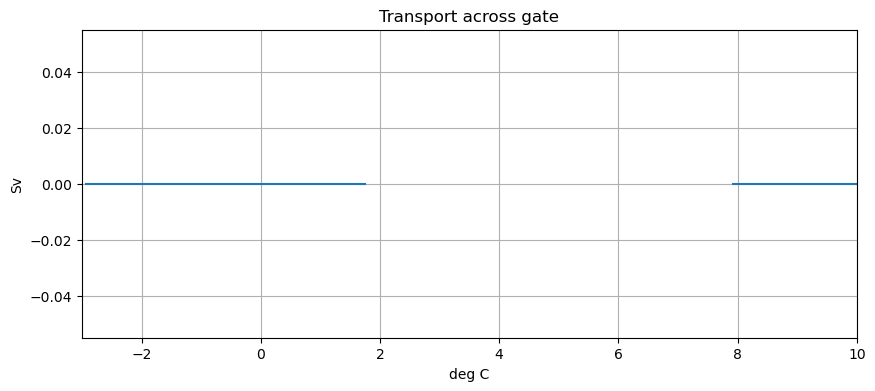

In [39]:
# as an example, we can look at the total advection (sum) in temperature divided by the binsTH
# we want to bin the values to create a mesh for each T bin

# look at the volume transport across the gate, then advective transport in x and diffusive transport in x
fig = plt.figure()

# # third subplot - s vs Sv
# ax = plt.subplot(121)
# data = perpendicular_vel*cell_area*1e-6
# tmps = np.zeros(binsSLT_centers.shape)
# for i in range (vol_gate.shape[0]):
#     for j in range(nz):
#         tmpbinsalt = binned_salinity_gate[i,j]
#         if not np.isnan(tmpbinsalt):
#             tmps[int(tmpbinsalt)] += data[j,i]
# ax.plot(binsSLT_centers,tmps)
# ax.set_xlim(33.5,35.5)
# ax.grid()
# ax.set_ylabel("Sv")
# ax.set_xlabel("PSU")
# ax.set_title("Transport across gate")


# fourth subplot - t vs Sv
indices = np.arange(0,len(y_curr),1)
# Uo,Vo = Uo[:,:-1,:-1],Vo[:,:-1,:-1]

uvelgate = aste_tracer2compact(Uo,nfx,nfy)
vvelgate = aste_tracer2compact(Vo,nfx,nfy)
uvelgate = uvelgate[:,y_curr,x_curr]
vvelgate = vvelgate[:,y_curr,x_curr]
perpendicular_vel = np.full(uvelgate.shape,np.nan) #    zeros_like(uvelgate)
for i in range(len(choose_UV)):
    if choose_UV[i][0] == "V":
        perpendicular_vel[i] = uvelgate[i]       # flipping the sign of this helps reproduce An plot but this seems wrong??
    elif choose_UV[i][0] == "H":
        #perpendicular_vel[i] = -vvelgate[i]
        perpendicular_vel[i] = vvelgate[i]
XV,YV= np.meshgrid(indices[::-1],mygrid['RC'])
data = perpendicular_vel*cell_area*1e-6

ax = plt.subplot(111)
tmpt = np.zeros(binsTH_centers.shape)
for i in range (vol_gate.shape[0]):
    for j in range(nz):
        tmpbintheta = binned_theta_gate[i,j]
        if not np.isnan(tmpbintheta):
            tmpt[int(tmpbintheta)] += data[j,i]

ax.plot(binsTH_centers,tmpt)
ax.set_xlim(-3,10)
ax.grid()
ax.set_ylabel("Sv")
ax.set_xlabel("deg C")
ax.set_title("Transport across gate")


# Create Jy and Jx

Jy is normalized by the width of the salt cells so is m/s/PSU. Jx is normalized by with of temp cells so m/s/degC

In [ ]:
# divide Gs and Gt by the thicknesses in salt (Jy) and temp (Jx)